### <font color=green> This is a query that I made while doing the SQL with PostgreSQL course from alura. </font>
    This code stats with the creation of the data base "alura" and the schema "academico".
    Then the tables "aluno", "categoria", "curso" and "aluno_curso" are made to store students data.
    Also the tables "Instrutor" and "Log_instrutor" are created to store teachers data.

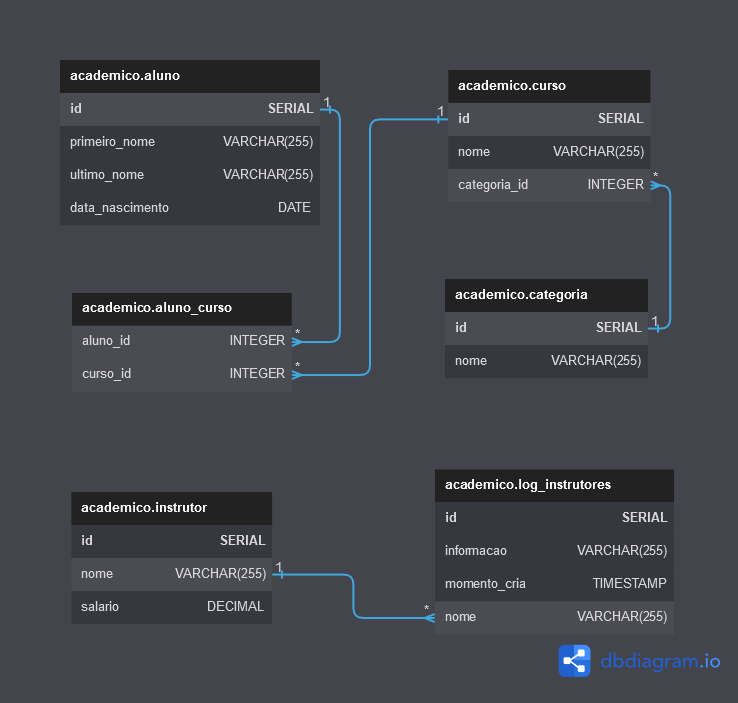

In [ ]:
CREATE DATABASE alura;
CREATE SCHEMA academico;

CREATE TABLE academico.aluno(
	id SERIAL PRIMARY KEY,
	primeiro_nome VARCHAR(255) NOT NULL,
	ultimo_nome VARCHAR(255) NOT NULL,
	data_nascimento DATE NOT NULL
);

CREATE TABLE academico.categoria(
	id SERIAL PRIMARY KEY,
	nome VARCHAR(255) NOT NULL UNIQUE
);

CREATE TABLE academico.curso(
	id SERIAL PRIMARY KEY,
	nome VARCHAR(255) NOT NULL,
	categoria_id INTEGER NOT NULL REFERENCES academico.categoria(id) ON DELETE CASCADE ON UPDATE CASCADE
);

CREATE TABLE academico.aluno_curso(
	aluno_id INTEGER NOT NULL REFERENCES academico.aluno(id) ON DELETE CASCADE ON UPDATE CASCADE,
	curso_id INTEGER NOT NULL REFERENCES academico.curso(id) ON DELETE CASCADE ON UPDATE CASCADE,
	PRIMARY KEY (aluno_id, curso_id)
);

CREATE TABLE academico.log_instrutores(
	id SERIAL PRIMARY KEY,
	informacao VARCHAR(255),
	momento_cria TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    nome VARCHAR(255) NOT NULL
);

CREATE TABLE academico.instrutor(
	id SERIAL PRIMARY KEY,
	nome VARCHAR(255) NOT NULL,
	salario DECIMAL NOT NULL
	);



Here are one function and one trigger: "cria_curso" and "cria_instrutor"

The "cria_curso" function is used to create a course with a name and category, also it looks if there is already a matching category on the "academico.categoria" table and if its not already there it create a new one.

The "cria_instrutor" trigger will trigger a salary check for every time a instructor were insert on the database. This trigger will compare the new employee salary with the database mean salaries and return the amount of emplyees who are paid less. Also the trigger will ensure that the new employee is not paid more than all others.


In [ ]:
CREATE OR REPLACE FUNCTION academico.cria_curso (nome_curso VARCHAR, nome_categoria VARCHAR) RETURNS void AS $$
	DECLARE
		id_categoria INTEGER;
	BEGIN
		SELECT id INTO id_categoria FROM academico.categoria WHERE academico.categoria.nome = nome_categoria;
		IF NOT FOUND THEN
			INSERT INTO academico.categoria(nome) VALUES (nome_categoria) RETURNING id INTO id_categoria;
		END IF;
		INSERT INTO academico.curso(nome, categoria_id) VALUES (nome_curso, id_categoria);
	END;
$$ LANGUAGE plpgsql;

CREATE OR REPLACE FUNCTION academico.cria_instrutor() RETURNS TRIGGER AS $$
	DECLARE
		media_salarial DECIMAL;
		instrutores_recebem_menos INTEGER DEFAULT 0;
		total_instrutores INTEGER DEFAULT 1;
		salario DECIMAL;
		percentual DECIMAL(5,2);
	BEGIN
		SELECT AVG(academico.instrutor.salario) INTO media_salarial FROM academico.instrutor WHERE id != NEW.id;
		
		IF NEW.salario > media_salarial THEN
			INSERT INTO academico.log_instrutores(informacao) VALUES (NEW.nome || 'recebe acima da média');
		END IF;
		
		FOR salario IN SELECT academico.instrutor.salario FROM academico.instrutor WHERE id != NEW.id LOOP
			total_instrutores := total_instrutores +1;
			
			IF NEW.salario > salario THEN 
				instrutores_recebem_menos := instrutores_recebem_menos + 1;
			END IF;
		END LOOP;
		
		percentual = instrutores_recebem_menos::DECIMAL / total_instrutores::DECIMAL *100;
		ASSERT percentual < 100::DECIMAL, 'Instrutores novos não podem receber mais que os demais';
		
		INSERT INTO academico.log_instrutores(informacao) 
			VALUES (NEW.nome || 'recebe mais que' || percentual || '% da grade de instrutores');
        
        INSERT INTO academico.log_instrutores(nome)
            VALUES(NEW.nome);
		RETURN NEW;
	END;
$$ LANGUAGE plpgsql;

CREATE TRIGGER cria_log_instrutor BEFORE INSERT ON academico.instrutor
	FOR EACH ROW EXECUTE FUNCTION academico.cria_instrutor();
